In [1]:
### README ###
'''
This is my first DS project in which I developed neural network model which can predict the price of used bicicles (road and mtb, seperately)
I used two datasets found on kaggle (linki) which included data scraped from bike-exchange.com and ebay.com. 

Cleaning and preprocessing data
Concated dataframe contained 500 columns with valuable data spreaded inbetween, it was a bit of struggle (or playing with pandas) to compress the data to 10 useful cathegories.  
Unfortunetly it required removing about 45% of source data, so finally I was left with:
- 2000 records for mtb bikes
- 2500 record for road bikes

Data was preprocessed in a few ways:
- scaled data - between 0 to 1 (bike gropset, frame material, brake type, suspension type)
the closer to 1 the better, f.e. 0.1 - shimano claris, 1 - shimano dura ace (the best groupset produced by shimano)
- 0/1 data - does bike has a feature or is it new or used (vast majority - used)
- year production was scaled with QuantileTransformer from sklearn, bacause of its long-tail distribution
- finally we've 4 datasets, mtb, road and each one one-hot encoded.

Training and results:
The stated goal was to predict the price within $100 of the true value.
I used standard neural network with linear layers and ReLu activation function.
Optuna helped me a lot with hyperparameters, I used 2 diffrent strategies:
- accurancy maximize
- loss minimize

Here are the results from the best obtained model:
<photo>

Raport from other models can be found there <link>
'''

'\nThis is my first DS project in which I developed neural network model which can predict the price of used bicicles (road or mtb)\nI used two datasets found on kaggle (linki) which included data scraped from two websites, \nbike-exchange.com - this dataset was well prepered, with few amount of columns wich contained valuable data\nebay.com - dataset included 500 columns which required a lot of struggle to compress the data to 10 cathegories \n\nThere were 3 significant stages of my project:\n- cleaning and preprocessing the data: \n    - merging 2 datasets into one (cleaning/preprocessing functions which I created universal and works god for both datasets)\n    - grouping types of bike, gropsets, brakes, suspension and extracting year of production, frame material, condition and wheel size  \n    - filling nans by median in very few instances, where it was safe \n    - mapping cathegorical data to numeric, I used linear scale for the most columns, although year production had a wide 

In [2]:
import pandas as pd 
import re
import numpy as np

df_exch = pd.read_json('data\\raw_sources\data_bike_exchange.json', lines=True)
df_ebay = pd.read_json('data\\raw_sources\data_ebay.json', lines=True)

df = pd.concat([df_exch, df_ebay], axis = 0).reset_index(drop=True)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df

C:\Users\Szymon\AppData\Local\Temp\ipykernel_17144\981704360.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,Title,Product URL,Price now,Price was,Photo URL,Brand,Type,Color,Frame in inches,Size,...,Rear Shock,Casette,Modell,Produktart,Radtyp,Customised,Scooter Type,Suitable For,Batterys,Marca
0,2018 heavily upgraded cannondale jekyll 2,https://www.bikeexchange.com/a/full-suspension...,"$3,250",na,https://marketplacer.imgix.net/d-/8g3ztnko8xqr...,cannondale,full suspension mountain bikes,yellow,"21""",large,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,specialized enduro fsr comp 29 2016,https://www.bikeexchange.com/a/full-suspension...,"now $3,500","$8,900",https://marketplacer.imgix.net/n6/1ts1xdzay3ti...,specialized,full suspension mountain bikes,matte black,"17""",medium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,giant anthem sx 27.5 2016,https://www.bikeexchange.com/a/full-suspension...,"now $1,799.99","$2,999.99",https://marketplacer.imgix.net/-q/n60hktmpow9p...,giant,full suspension mountain bikes,green,"20""",large,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cannondale trigger 27.5 carbon black inc. 2015,https://www.bikeexchange.com/a/full-suspension...,"now $6,999.99","$11,290",https://marketplacer.imgix.net/ac/sh5gats79aax...,cannondale,full suspension mountain bikes,black,"17"", 19""","medium, large",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,haro shift r9 lt 2017,https://www.bikeexchange.com/a/full-suspension...,"now $1,699.99","$2,719.99",https://marketplacer.imgix.net/wp/tcssaskbikzg...,haro,full suspension mountain bikes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,vintage raleigh ladies bike + basket,https://www.ebay.co.uk/itm/vintage-raleigh-lad...,NaN,NaN,https://i.ebayimg.com/thumbs/images/g/qh0aaosw...,raleigh,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10048,men's giant mountain bike,https://www.ebay.co.uk/itm/mens-giant-mountain...,NaN,NaN,https://i.ebayimg.com/thumbs/images/g/3q8aaosw...,giant,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10049,kuota kom evo carbon road bike,https://www.ebay.co.uk/itm/kuota-kom-evo-carbo...,NaN,NaN,https://i.ebayimg.com/thumbs/images/g/0m8aaosw...,kuota,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10050,dawes atlantis 25.25 inch bike,https://www.ebay.co.uk/itm/dawes-atlantis-25-2...,NaN,NaN,https://i.ebayimg.com/thumbs/images/g/qvwaaosw...,dawes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def print_nans_perc(df : (pd.DataFrame, pd.Series), p = False, perc = 0.95, sort_by = 'val'):
    n = len(df)
    nans_perc = df.isna().sum() / n
    print('len - ', n)
    if type(df) == pd.DataFrame:
        if sort_by == 'val':
            nans_perc.sort_values(ascending=True, inplace=True)
        else:
            nans_perc.sort_index(inplace = True)
        if p:
            for index, val in nans_perc.items():
                print(index + ': ', val)
            print('\n')
        cols = nans_perc[nans_perc > 0.95].index
        return cols
    elif type(df) == pd.Series:
        if p:
            print('left_nans: ', nans_perc)
    return
print_nans_perc(df, p = True)

len -  10052
Title:  0.0
Photo URL:  0.0
ID:  0.0
Product URL:  0.0
Brand:  0.03223239156386789
Condition:  0.19717469160366097
Price:  0.19717469160366097
Seller notes:  0.19717469160366097
Wheel Size:  0.35535216872264225
Frame Size:  0.40191006764822923
Type:  0.4340429765220852
Bike Type:  0.5213887783525667
Vintage:  0.5239753282928771
Material:  0.570533227218464
Color:  0.5764027059291683
Brake Type:  0.583366494230004
Model:  0.6192797453243136
Gender:  0.6606645443692798
Handlebar Type:  0.6840429765220851
Department:  0.697174691603661
Frame Material:  0.7100079586152009
Number of Speeds:  0.7123955431754875
MPN:  0.759550338241146
Configuration:  0.7654198169518504
Colour:  0.7766613609231994
Model Year:  0.7975527258257064
Price was:  0.802825308396339
Price now:  0.802825308396339
Availability:  0.802825308396339
Item condition:  0.802825308396339
Suspension:  0.8185435734182253
Suspension Type:  0.8265021886191802
Gear Change Mechanism:  0.8273975328292877
UPC:  0.8307799

Index(['Modified Item', 'Custom Bundle', 'Tire Type', 'Custom-Built',
       'Shifter', 'Tires', 'EAN', 'Weight', 'Non-Domestic Product',
       'Frame Number',
       ...
       'Rear Tire', 'Vehicle size', 'Pedals', 'Sizes Available',
       'Product type', 'Components', 'Chainring configuration', 'Brand.',
       'Wheel Set', 'Marca'],
      dtype='object', length=372)

In [4]:
def drop_nans_in_cols(df : pd.DataFrame, cols : list):
    print(len(df))
    df.dropna(subset=cols, inplace=True)
    df.dropna(axis = 1, how = 'all', inplace=True)
    print(len(df))
    print_nans_perc(df)

In [5]:
road_groups = ['road bike', 'road bike - racing', 'road bike', 'road bike - touring', 'road', 'cyclocross bike', 'cyclocross/gravel', 'road disc bike', 'road bike - racing or touring', 
            'aero road bike', 'racing/touring roadbike', 'road/touring', 'time trial/triathlon bike', 'road bike racing', 'time trial/triathlon', 'road/racing', 'racing/road bike', 
            'raod bike', 'road racing bike', 'road bike', 'road bike - touring ??', 'road bike / triathlon', 'racing/road bike', 'comfort road bike',  'road bike', 'road bike / racing bike', 'hybrid', 
            'gravel, cx, road, commuter', 'road bike / cyclocross bike / triathlon', 'race road bike', 'road bike - racing', 'gravel bike', 'road bike - touring', 'racing bike', 'road bike racing', "road", 'road bike', 'road bikes',]

mtb_groups = ['mountain bike', 'full suspension', 'downhill bike', 'mountain bike', 'mountain bike/ gravel', 'mountain bike mtb 29er', 'mountain suspension bike', 'hardtail bike','mountain bike', 'mountain  bike style', 
            'hardtail mountain bike', 'mountain', 'mountain bike', 'mountain bike19"', 'enduro', '29er mountain bike', 'mountain / jump bike', 'mountain bike mtb 29er', 'hardtail bike', 'downhill bike', 'full suspension mountain bikes', 
            'hardtail mountain bikes', 'rigid mountain bikes', 'mountain bikes', 'mtb', 'mountain', 'fat bike']

types_dict = {'road bike': 'road bike',  'road bike - racing': 'road bike',  'road bike': 'road bike',  'road bike - touring': 'road bike',  'road': 'road bike',  'cyclocross bike': 'road bike',  'cyclocross/gravel': 'road bike',  
            'road disc bike': 'road bike',  'road bike - racing or touring': 'road bike',  'aero road bike': 'road bike',  'racing/touring roadbike': 'road bike',  'road/touring': 'road bike',  'time trial/triathlon bike': 'road bike', 
            'road bike racing': 'road bike',  'time trial/triathlon': 'road bike',  'road/racing': 'road bike',  'racing/road bike': 'road bike',  'raod bike': 'road bike',  'road racing bike': 'road bike',  'road bike': 'road bike',  
            'road bike - touring ??': 'road bike',  'road bike / triathlon': 'road bike',  'racing/road bike': 'road bike',  'comfort road bike': 'road bike',   'road bike': 'road bike',  'road bike / racing bike': 'road bike',  'hybrid': 'road bike',  
            'gravel, cx, road, commuter': 'road bike',  'road bike / cyclocross bike / triathlon': 'road bike',  'race road bike': 'road bike',  'road bike - racing': 'road bike',  'gravel bike': 'road bike',  'road bike - touring': 'road bike',  
            'racing bike': 'road bike',  'road bike racing': 'road bike',  "road": 'road bike', 'road bike': 'road bike',  'road bikes': 'road bike', 'mountain bike': 'mtb',  'full suspension': 'full',  'downhill bike': 'full',  'mountain bike': 'mtb',  
            'mountain bike/ gravel': 'mtb',  'mountain bike mtb 29er': 'mtb',  'mountain suspension bike': 'mtb',  'hardtail bike': 'hard', 'mountain bike': 'mtb',  'mountain  bike style': 'mtb',  'hardtail mountain bike': 'hard',  'mountain': 'mtb',  
            'mountain bike': 'mtb',  'mountain bike19"': 'mtb',  'enduro': 'full',  '29er mountain bike': 'mtb',  'mountain / jump bike': 'mtb',  'mountain bike mtb 29er': 'mtb',  'hardtail bike': 'hard',  'downhill bike': 'full',  
            'full suspension mountain bikes': 'full',  'hardtail mountain bikes': 'hard',  'rigid mountain bikes': 'mtb',  'mountain bikes': 'mtb', 'mountain': 'mtb', 'fat bike': 'mtb'}

def find_from_list(row, columns, list):
    for col in columns:
        value = row[col]
        found = ''
        if pd.notna(value) and isinstance(value, str): 
            found = re.findall(r'(' + '|'.join(list) + ')', value, re.IGNORECASE)
        if found:
            return str(found[0]).lower()
    return np.nan

def make_num_cat(df_orig : pd.DataFrame, col_name : str, cat_list : list, dictonary: dict, find_cols = [], find_fn = find_from_list, num_type = float):
    if find_cols == []:
        find_cols = df_orig.columns
    cat_col = col_name + '_cat'
    num_col = col_name + '_num'
    df = df_orig.copy()
    df[[cat_col, num_col]] = np.nan
    df[cat_col] = df.apply(find_fn, axis = 1, args = (find_cols, cat_list))
    print_nans_perc(df[cat_col], p = True)
    df[num_col] = df[cat_col].map(dictonary)
    df[num_col] = df[num_col].astype(num_type)
    return df

cols_ty = ['Bike Type', 'Type', 'Title', 'Seller notes', 'Product URL']
df = make_num_cat(df, 'type', road_groups + mtb_groups, types_dict, cols_ty, num_type=str)
df['type'] = df['type_num']
df.drop(columns=['type_num', 'type_cat'], inplace=True)
print_nans_perc(df['type'], p=1)
df.groupby('type').size()

len -  10052
left_nans:  0.0007958615200955034
len -  10052
left_nans:  0.0


type
full          523
hard          487
mtb          3649
nan            27
road bike    5366
dtype: int64

In [6]:
df['Price'] = df['Price'].combine_first(df['Price now'])
df['Price'].replace('[A-Za-z, \$, £]','',inplace=True, regex=True)
df = df[df['Price'] != '']
df['Price'] = df['Price'].astype(float)
print_nans_perc(df['Price'], p=1)

len -  10030
left_nans:  0.0


In [7]:
gear_to_group_dict_road = {
        '1990 2003': {
               8.0: 'sora',
               9.0: 'ultegra',
        },
        '2004 2008': {
               8.0:'sora',
               9.0: '105',           
               10.0: 'dura ace',
            },
        '2009 2013': {
               6.0: 'tourney',
               8.0: 'sora',   
               9.0: 'deore',
               10.0: '105',
               11.0: 'ultegra',
        },
        '2014 2016': {
               7.0: 'tourney',
               8.0: 'claris',
               9.0: 'sora',
               10.0: '105',
               11.0: 'ultegra',
        },
        '2017 2023': {
               5.0: 'tourney',
               6.0: 'tourney',
               7.0: 'tourney',
               8.0: 'claris',
               9.0: 'sora',
               10.0: '105',
               11.0: 'ultegra',
               12.0: 'dura ace',
          }         
     }
gear_to_group_dict_mtb = {
          '1990 2003': {
               7.0:'altus',
               8.0: 'deore',
               9.0:'xtr',
               },
          '2004 2008':{
               8.0: 'altus',
               9.0: 'deore xt',
               10.0:'xtr',
          },
          '2009 2013': {
               6.0: 'tourney',
               8.0: 'altus',
               9.0: 'deore',
               10.0: 'xtr',
               11.0: 'ultegra',
          },
          '2014 2016': {
               7.0: 'tourney',
               8.0: 'tourney',
               9.0: 'altus',
               10.0: 'deore xtr',
               11.0: 'xtr',
          },
          '2017 2023': {
               5.0: 'tourney',
               6.0: 'tourney',
               7.0: 'tourney',
               8.0: 'tourney',
               9.0:'altus',
               10.0: 'deore',
               11.0: 'deore xt',
               12.0:'xtr',
          }
     }

bike_groups = [
    "Dura Ace", "Dura-Ace", "Ultegra", "105", "Tiagra", "Sora", "Claris", "GRX",
    
    "XTR", "Deore XT", "SLX", "Deore", "Alivio", "Acera", "Altus", "Tourney", "Zee", "Saint",
    
    "Super Record", "Record", "Chorus", "Potenza", "Centaur", "Veloce", "Athena",
    
    "Sram Red", "Force", "Rival", "Apex",

    "XX1", "X01","GX", "NX", "SX", "XX", "X0", "X9", "X7", "X5", "Descendant", "Code"
]

road_groups = [ "dura ace", "dura-ace", "ultegra", "105", "tiagra", "sora", "claris", "grx",
               "super record", "record", "chorus", "potenza", "centaur", "veloce", "athena",
                "sram red", "Force", "arval", "apex"]

mtb_groups = [
    "xtr", "deore xt", "slx", "deore", "alivio", "acera", "altus", "tourney", "zee", "saint",
    "xx1", "x01", "gx", "nx", "sx", "xx", "x0", "x9", "x7", "x5", "descendant", "code"
]

bike_groups_dict = {
    "dura ace": 1.0, "dura-ace": 1.0, "ultegra": 0.9, "105": 0.8, "tiagra": 0.7, "sora": 0.6, "claris": 0.5, "grx": 0.8,
    
    "xtr": 1.0, "deore xt": 0.9, "slx": 0.8, "deore": 0.7, "alivio": 0.6, "acera": 0.5, "altus": 0.4, "tourney": 0.3, "zee": 0.8, "saint": 0.9,
    
    "super record": 1.0, "record": 0.9, "chorus": 0.8, "potenza": 0.7, "centaur": 0.6, "veloce": 0.5, "athena": 0.4,
    
    "sram red": 1.0, "force": 0.9, "rival": 0.8, "apex": 0.7,
    
    "xx1": 1.0, "x01": 0.9, "gx": 0.8, "nx": 0.7, "sx": 0.6, "xx": 0.9, "x0": 0.8, "x9": 0.7, "x7": 0.6, "x5": 0.5, "descendant": 0.7, "code": 0.7
}


df.drop(['Color', 'Colour', 'Product URL', 'Photo URL'], axis=1, inplace=True)

In [8]:
def find_year(row, cols):
    for col in cols:
        value = row[col]
        if pd.notna(value) and isinstance(value, str):
            four_num = re.findall(r'\b[0-9]{4}\b', value)
            four_num = [float(num) for num in four_num]
            for num in four_num:
                if 1950 <= num <= 2024:
                    return num
    return np.nan

df['Production_year'] = np.nan
cols = ['Model Year','Title'] 
#cols = df.columns
df['Production_year'] = df.apply(find_year, axis=1, args=(cols,))
print_nans_perc(df['Production_year'], p=True)

len -  10030
left_nans:  0.5399800598205384


In [9]:
cols_gp = ['Title', 'Seller notes', 'Model', 'Brake Type', 'Gear Change Mechanism', 'Groupset', 'Rear Derailleur']
df = make_num_cat(df, 'groupset', bike_groups, bike_groups_dict, cols_gp)
df['groupset_cat']
df[df['type'] == 'mtb'].groupby('groupset_cat').size().sort_values(ascending=False)

len -  10030
left_nans:  0.6236291126620139


groupset_cat
xtr         124
xx1          50
x01          35
deore        31
gx           29
xx           18
sx           18
slx          16
nx           15
deore xt     14
x9           14
force         9
saint         6
x7            5
x5            4
code          4
tourney       3
105           2
x0            2
acera         2
rival         2
altus         2
zee           2
record        1
apex          1
alivio        1
dtype: int64

In [10]:
df['speeds'] = df['Number of Speeds'].combine_first(df['Number of Gears'])
df['speeds_num'] = df['speeds'].str.extract(r'\b(\d{1,2})\b').astype(float)

def re_count_gears(x):
    if x < 5 or x > 33:
        return np.nan
    elif x <= 12:
        return x
    else:
        if x % 2 == 0:
            if x/2 > 12:
                return np.nan
            else:
                return x/2
        elif x % 3 == 0:
            return x/3

speeds_dict_num = {5: 0.2, 6: 0.3, 7: 0.4, 8: 0.5, 9: 0.6, 10: 0.7, 11: 0.8, 12: 0.9}
df['speeds_num'] = df['speeds_num'].apply(re_count_gears)

In [11]:
speeds_road_dict_cat = {5: 'tourney', 6: 'tourney', 7: 'claris', 8: 'sora', 9: 'tiagra', 10: '105', 11: 'ultegra', 12: 'dura ace'}
speeds_mtb_dict_cat = {5: 'tourney', 6: 'tourney', 7: 'altus', 8: 'acera', 9: 'alivio', 10: 'deore', 11: 'deore xt', 12: 'xtr'}
def assign_group(row, gear_to_group_dict_road, gear_to_group_dict_mtb):
    bike_type, year, speed = row['type'], row['Production_year'], row['speeds_num']
    if pd.isna(speed):
        return np.nan
    gear_to_group_dict = gear_to_group_dict_road if bike_type == 'Road Bike' else gear_to_group_dict_mtb
    if pd.isna(year):
        return gear_to_group_dict['2017 2023'][speed]

    for time_peroid in gear_to_group_dict:
        start, end = map(float, time_peroid.split())
        if start <= year <= end:
            if speed in gear_to_group_dict[time_peroid]:
                return gear_to_group_dict[time_peroid][speed]
    return np.nan

df['speeds_cat'] = df.apply(assign_group, axis=1, args=(gear_to_group_dict_road, gear_to_group_dict_mtb, ))
df['groupset_cat'] = df['groupset_cat'].combine_first(df['speeds_cat'])
df['groupset_num'] = df['groupset_cat'].map(bike_groups_dict)

print_nans_perc(df['groupset_num'], p=True)

len -  10030
left_nans:  0.37058823529411766


In [12]:
materials = ['carbon', 'alu', 'aluminium', 'steel', 'alloy', 'titanium', 'chromoly']
materials_dict = {'carbon': 0.9, 'alu': 0.5, 'aluminium': 0.5, 'steel': 0.3, 'alloy': 0.5, 'titanium': 0.6, 'chromoly': 0.15}

cols_mt = ['Title', 'Seller notes', 'Model', 'Frame Material', 'Material', 'Fork Material', 'Rim Material']
df = make_num_cat(df, 'material', materials, materials_dict, find_cols=cols_mt)
df['material_cat']

len -  10030
left_nans:  0.2621136590229312


0        carbon
1           alu
2        carbon
3        carbon
4           alu
          ...  
10047     steel
10048     alloy
10049    carbon
10050       NaN
10051       NaN
Name: material_cat, Length: 10030, dtype: object

In [13]:
e_shift = ['di2', 'axs', 'etap']
e_shift_dict = {'di2': 1, 'axs': 1, 'etap': 1, np.nan: 0}

e_cols = ['Title', 'Seller notes', 'Model', 'Gear Change Mechanism', 'Features', 'Shifter Style']
df = make_num_cat(df, 'e_shift', e_shift, e_shift_dict, find_cols=e_cols)
df['e_shift_cat'].fillna('null', inplace=True)

len -  10030
left_nans:  0.940777666999003


In [14]:
df = df[df['Condition'] != 'for parts or not working']
condition_dict = {'used': 0, 'new': 1, 'new other (see details)': 1, 'seller refurbished': 0, 'manufacturer refurbished': 0, '--': 0}

df['Condition'] = df['Condition'].combine_first(df['Item condition'])
df['isNew'] = df['Condition'].replace(condition_dict, regex=True)
df['isNew'] = df['isNew'].astype(float)
print_nans_perc(df['isNew'], p = True)
df.groupby('isNew').size().sort_values()

len -  9995
left_nans:  0.0


isNew
1.0    3983
0.0    6012
dtype: int64

In [15]:
brakes = ['rim', 'disc', 'v-brake', 'hydraulic', 'caliper', 'cantilever', 'v-brakes']
brakes_dict = {'rim': 0.5, 'disc': 1, 'v-brake': 0.5, 'hydraulic': 1, 'caliper': 0.5, 'cantilever': 0.5, 'v-brakes': 0.5}

cols_br = ['Title', 'Seller notes', 'Model', 'Brake Type', 'Braking Type']
df = make_num_cat(df, 'brake', brakes, brakes_dict, find_cols=cols_br)

len -  9995
left_nans:  0.4753376688344172


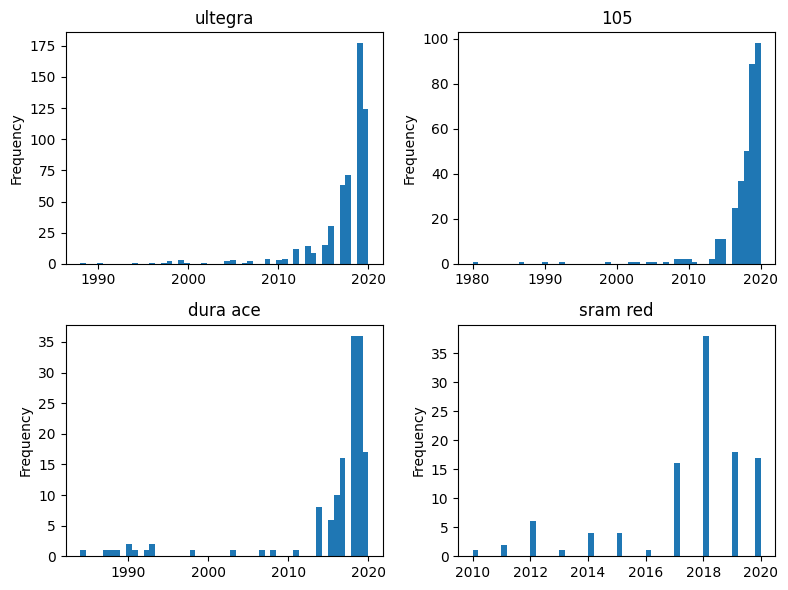

In [16]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2, figsize = (8,6))

df[df['groupset_cat'] == 'ultegra']['Production_year'].plot(kind='hist', bins=50, title='ultegra', ax=axs[0,0])
df[df['groupset_cat'] == '105']['Production_year'].plot(kind='hist', bins=50, title='105', ax=axs[0,1])
df[df['groupset_cat'] == 'dura ace']['Production_year'].plot(kind='hist', bins=50, title='dura ace', ax=axs[1,0])
df[df['groupset_cat'] == 'sram red']['Production_year'].plot(kind='hist', bins=50, title='sram red', ax=axs[1,1])
plt.tight_layout()
plt.show()

groupset_median = df.groupby('groupset_cat')['Production_year'].median()[df.groupby('groupset_cat').size() > 60]

In [17]:
print_nans_perc(df['Production_year'], p = 1)
df.loc[df['groupset_cat'].isin(groupset_median.index), 'Production_year'] = df.loc[df['groupset_cat'].isin(groupset_median.index), 'Production_year'].fillna(df['groupset_cat'].map(groupset_median.to_dict()))
print_nans_perc(df['Production_year'], p = 1)

len -  9995
left_nans:  0.5394697348674338
len -  9995
left_nans:  0.27073536768384193


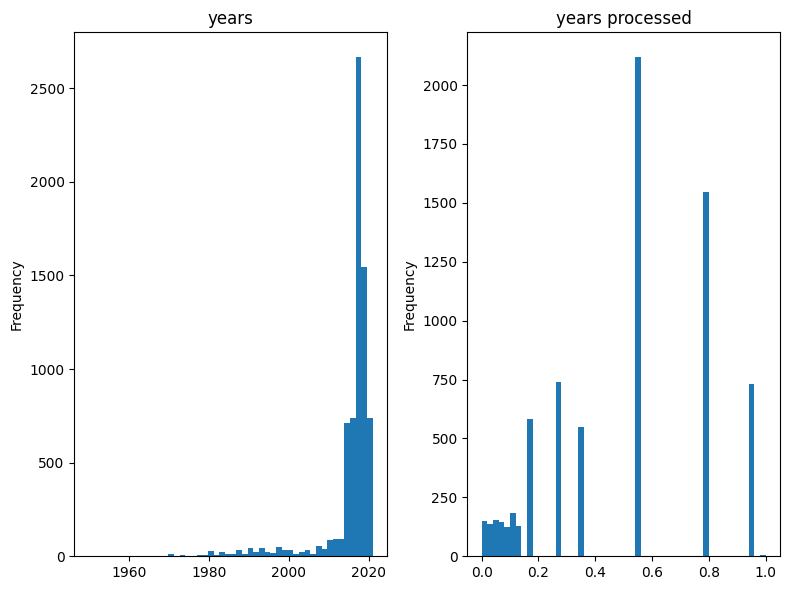

0        0.541507
1        0.270307
2        0.270307
3        0.179405
4        0.358672
           ...   
10047    0.007821
10048    0.541507
10049         NaN
10050    0.010634
10051    0.541507
Name: year_num, Length: 9995, dtype: float64

In [18]:
from sklearn.preprocessing import QuantileTransformer

min = 1950
max = 2020
df['year_num'] = df['Production_year'].apply(lambda x: (x - min)/(max - min))

notna_idx = df.index[df['Production_year'].notna()]
arr = df.loc[notna_idx, 'Production_year'].to_numpy()
arr = arr.reshape(-1, 1)
qt = QuantileTransformer(n_quantiles=len(arr), output_distribution='uniform')
arr = qt.fit_transform(arr)
arr = arr.flatten()
df.loc[notna_idx,'year_num'] = arr

fig, axs = plt.subplots(1, 2, figsize=(8, 6)) 

df['Production_year'].plot(kind='hist', bins=50, ax=axs[0], title='years')
df['year_num'].plot(kind='hist', bins=50, ax=axs[1], title='years processed')

plt.tight_layout()
plt.show()
df['year_num']

In [19]:
cols = print_nans_perc(df)
to_drop = ['Frame Size', 'Department', 'UPC', 'Gender', 'Shifter Style', 
              'Features', 'Country/Region of Manufacture', 'Tyre Type', 'Style', 'Manufacturer Color', 'Tire Type',
              'Modified Item', 'Tires', 'Custom-Built', 'Custom Bundle', 'Handlebar Type', 'Shifter', 'Gear Change Mechanism', 
              'Model Year', 'Configuration', 'Frame Material', 'Brake Type', 'Condition', 'Number of Gears', 'speeds', 'Number of Speeds', 
              'Material', 'speeds_num', 'Vintage', 'Model', 'Brand', 'speeds_cat', 'MPN','Size', 'Rear Derailleur', 'Braking Type', 
              'Groupset', 'Riding Style', 'Frame in inches', 'Size CM', 'Availability', 'Item condition', 'Price was', 'Price now', 'Type', 'Bike Type']
to_drop += list(cols)

df_drp = df.drop(to_drop, axis = 1, inplace=False)
print_nans_perc(df_drp, p=True)


len -  9995
len -  9995
Title:  0.0
isNew:  0.0
ID:  0.0
Price:  0.0
e_shift_num:  0.0
e_shift_cat:  0.0
type:  0.0
Seller notes:  0.19609804902451225
material_num:  0.26143071535767887
material_cat:  0.26143071535767887
year_num:  0.27073536768384193
Production_year:  0.27073536768384193
Wheel Size:  0.3550775387693847
groupset_cat:  0.3660830415207604
groupset_num:  0.3697848924462231
brake_num:  0.4753376688344172
brake_cat:  0.4753376688344172
Suspension:  0.8183091545772886
Suspension Type:  0.8259129564782391




Index([], dtype='object')

In [20]:
roadies = df_drp[df_drp['type'] == 'road bike'].reset_index(drop=1)

cols_to_drop_road = ['Wheel Size', 'Suspension', 'Suspension Type', 'Seller notes']
roadies.drop(columns=cols_to_drop_road, inplace=True)
print_nans_perc(roadies, p=1)

len -  5342
Title:  0.0
ID:  0.0
Price:  0.0
type:  0.0
e_shift_cat:  0.0
e_shift_num:  0.0
isNew:  0.0
material_cat:  0.21022089105204042
material_num:  0.21022089105204042
Production_year:  0.25009359790340696
year_num:  0.25009359790340696
groupset_cat:  0.3189816548109322
groupset_num:  0.3219767877199551
brake_cat:  0.3938599775365032
brake_num:  0.3938599775365032




Index([], dtype='object')

In [21]:
old_idx = roadies.loc[roadies['Production_year'] < 2016].index
roadies.loc[old_idx, 'brake_num'] = 0.5
roadies.loc[old_idx, 'brake_cat'] = 'rim'
print_nans_perc(roadies['brake_num'], p = 1)

len -  5342
left_nans:  0.33395731935604644


In [22]:
mtb = df_drp[df_drp['type'].isin(['mtb', 'full', 'hard'])]

print_nans_perc(mtb, p=True)

len -  4626
Title:  0.0
ID:  0.0
Price:  0.0
isNew:  0.0
e_shift_num:  0.0
type:  0.0
e_shift_cat:  0.0
Wheel Size:  0.17185473411154345
Seller notes:  0.21184608733246865
year_num:  0.29334198011240814
Production_year:  0.29334198011240814
material_cat:  0.3201469952442715
material_num:  0.3201469952442715
groupset_cat:  0.4210981409424989
groupset_num:  0.4256376999567661
brake_cat:  0.5691742325983571
brake_num:  0.5691742325983571
Suspension Type:  0.745136186770428
Suspension:  0.7955036748811067




Index([], dtype='object')

In [23]:
wheel_size = ['26', '27.5', '27', '27.5', '29', '650b', '24']
wheel_size_dict = {'27.5': 0.66, '29': 1, '27': 0.66, '27,5': 0.66, '26': 0.33, '650b': 0.66, '24': 0.25}

mtb = make_num_cat(mtb, 'wheel', wheel_size, wheel_size_dict)

len -  4626
left_nans:  0.16817985300475574


In [24]:
mtb['suspension'] = mtb['Suspension'].combine_first(mtb['Suspension Type'])
mtb.drop(columns=['Suspension', 'Suspension Type'], inplace=True)
mtb.loc[mtb['suspension'].isin(['full suspension (front & rear)','front & rear (full)']), 'suspension'] = 'full'

In [25]:
susps = ['front', 'full', 'no suspension', 'rear', 'hard']
susps_dict = {'front': 0.5, 'full': 1, 'no suspension': 0, 'rear': 1, 'hard': 0.5}

sus_cols = ['suspension', 'type']
mtb = make_num_cat(mtb, 'susp', susps, susps_dict, find_cols=sus_cols)

len -  4626
left_nans:  0.36230004323389536


In [26]:
old_idx = mtb.loc[mtb['Production_year'] > 2010].index
mtb.loc[old_idx, 'brake_num'] = 1
mtb.loc[old_idx, 'brake_cat'] = 'disc'
print_nans_perc(mtb['brake_cat'], p=1)

len -  4626
left_nans:  0.2438391699092088


In [28]:
mtb_num = mtb.drop(columns=['groupset_cat', 'brake_cat', 'material_cat', 'type', 'Wheel Size', 'wheel_cat', 'Seller notes', 'Title', 'suspension', 'susp_cat', 'e_shift_cat', 'Production_year'])
mtb_cat = mtb.drop(columns=['groupset_num', 'brake_num', 'material_num', 'type', 'Wheel Size', 'wheel_num', 'Seller notes', 'Title', 'suspension', 'susp_num', 'Production_year'])
print_nans_perc(mtb_cat, p=True)

mtb_num.dropna(axis=0, how='any', inplace=True)
mtb_cat.dropna(axis=0, how='any', inplace=True)
num_cols = ['ID', 'Price','year_num', 'isNew', 'susp_num','material_num', 'groupset_num', 'e_shift_num', 'wheel_num', 'brake_num']
cat_cols = ['ID', 'Price','year_num', 'isNew', 'susp_cat','material_cat', 'groupset_cat', 'e_shift_cat', 'wheel_cat', 'brake_cat']
mtb_num = mtb_num[num_cols]
mtb_num.to_csv('data\mtb_num.csv')

mtb_one_hot = pd.get_dummies(mtb_cat, columns=['susp_cat','material_cat', 'groupset_cat', 'e_shift_cat', 'wheel_cat', 'brake_cat'])
mtb_one_hot.to_csv('data\mtb_one_hot.csv')

print_nans_perc(roadies, p=True, sort_by='idx')
print_nans_perc(roadies.dropna(axis=0, how='any'), p=True, sort_by='idx')
roadies_num = roadies.drop(columns=['type', 'Title', 'groupset_cat', 'brake_cat', 'material_cat', 'e_shift_cat', 'Production_year'])
roadies_cat = roadies.drop(columns=['groupset_num', 'brake_num', 'material_num', 'type', 'Title', 'e_shift_num', 'Production_year'])
roadies_num.dropna(axis=0, how='any', inplace=True)
roadies_cat.dropna(axis=0, how='any', inplace=True)

roadies_num.to_csv('data\\road_num.csv')

roadies_one_hot = pd.get_dummies(roadies_cat, columns=['groupset_cat', 'brake_cat', 'material_cat', 'e_shift_cat'])
roadies_one_hot.to_csv('data\\road_one_hot.csv')


len -  4626
ID:  0.0
Price:  0.0
e_shift_cat:  0.0
e_shift_num:  0.0
isNew:  0.0
wheel_cat:  0.16817985300475574
brake_cat:  0.2438391699092088
year_num:  0.29334198011240814
material_cat:  0.3201469952442715
susp_cat:  0.36230004323389536
groupset_cat:  0.4210981409424989


len -  5342
ID:  0.0
Price:  0.0
Production_year:  0.25009359790340696
Title:  0.0
brake_cat:  0.33395731935604644
brake_num:  0.33395731935604644
e_shift_cat:  0.0
e_shift_num:  0.0
groupset_cat:  0.3189816548109322
groupset_num:  0.3219767877199551
isNew:  0.0
material_cat:  0.21022089105204042
material_num:  0.21022089105204042
type:  0.0
year_num:  0.25009359790340696


len -  2675
ID:  0.0
Price:  0.0
Production_year:  0.0
Title:  0.0
brake_cat:  0.0
brake_num:  0.0
e_shift_cat:  0.0
e_shift_num:  0.0
groupset_cat:  0.0
groupset_num:  0.0
isNew:  0.0
material_cat:  0.0
material_num:  0.0
type:  0.0
year_num:  0.0


